In [0]:
!pip install git+https://github.com/statsmodels/statsmodels.git


  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-li5xrwkw
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-li5xrwkw
  Stored in directory: /tmp/pip-ephem-wheel-cache-h6lgcrw5/wheels/7b/bd/6d/3192a61f34609bda0eea70342907984dba2ad17c3abb502ce7
Successfully built statsmodels
  Found existing installation: statsmodels 0.10.0
    Uninstalling statsmodels-0.10.0:
      Successfully uninstalled statsmodels-0.10.0


In [0]:
!pip install -q spams

     |████████████████████████████████| 1.9MB 5.0MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import sklearn
import math
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
from sklearn.ensemble import RandomForestRegressor
import spams
from numpy import trapz
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from copy import copy, deepcopy
###################################
#  LASSO

def Lasso_lambda(x,y,lambda1):
  param = {
    'lambda1' : lambda1, # not more than 20 non-zeros coefficients
    'lambda2' : 0,
    'L': x.shape[1],
    'mode' : 2 }       
  y= np.reshape(y, (y.shape[0], 1))  
  (A,path) = spams.lasso(np.asfortranarray(y),np.asfortranarray(x),return_reg_path = True,**param)
  return path,A 

#################################
def kfold_CV(X,y,cv):
  lambdas=np.arange(0.001,0.01,0.001)
  table=np.zeros((lambdas.shape[0],cv))
  sumscore=np.zeros((lambdas.shape[0],1))
  kf = KFold(n_splits=cv)
  i=0 
  j=0
  for lambda_ in lambdas:
    i=i+1 
    j=0
    for train_index, test_index in kf.split(X):
        j=j+1          
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]  
        (path,A)=Lasso_lambda(X_train,y_train,lambda_)          
        y_pred=PredictCV(X_test,X_train,path)
        table[i-1][j-1]=mean_squared_error(y_test, y_pred)
       
  for i in range(lambdas.shape[0]):
    sumscore[i,0]=np.sum(table[i,:], axis=0)   
  lambda_best=lambdas[np.argmin(sumscore)]
  return lambda_best 
#########################################
def PredictCV(X_test,X_train,path):
  coefs=path[:,X_train.shape[1]]
  Xm=np.copy(X_test)
  for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
      Xm[j,i]=X_test[j,i]*coefs[i]
  y_pred=np.zeros((X_test.shape[0],1))
  for i in range(X_test.shape[0]):
    y_pred[i,0]=np.sum(Xm[i,:], axis=0)
  return y_pred
###################################
#Stability Selection using LASSO

def indexmul(X,f):
  a=X.shape
  XX=np.copy(X)
  for i in range(a[1]):
    XX[:,i] = X[:,i]*f[i]
  return XX

def stability_selection(x,y,R,alpha,cv):
  (n,p)=x.shape
  halfsize=math.floor(n/2)
  freq = np.full((x.shape[1],x.shape[1]+1), 0,dtype=float)
  #lambda_cv=kfold_CV(x,y,cv)
  param = {
    'lambda1' : 0.00001, # not more than 20 non-zeros coefficients
    'lambda2' : 0,
    'L': x.shape[1],
    'mode' : 2 }       
  y= np.reshape(y, (y.shape[0], 1))
  pr={}
  for i in range(0,R):
    xs=indexmul(x,(alpha + (1-alpha)*np.random.uniform(0,1,p)))
    perm=np.random.permutation(n)
    pr[i] = perm[1:halfsize]
    
    (A,path) = spams.lasso(np.asfortranarray(y[( pr[i]),:]),np.asfortranarray(xs[( pr[i]),:]),return_reg_path = True,**param)
    
    freq=freq+abs(np.sign(path[:,0:x.shape[1]+1]))
  Area=np.full((1, x.shape[1]), 0,dtype=float) 
  for i in range(x.shape[1]):
    y = freq[i,1:x.shape[1]+1]
    Area[0][i]=(trapz(y))/(R*x.shape[1])
  return 1-Area.reshape(-1,1) 
######################
# Find t-statistics of linear regression

def get_confidence_OLS_wald(X,y):
  model = sm.OLS(y, X).fit()
  #return abs(model.tvalues.reshape(-1,1))
  return model.pvalues.reshape(-1,1)
###########################
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return p
##########################
def get_confidence_OLS_lr(predictors,target):

  number=predictors.shape[1]
  pval=np.full((1, number), 0,dtype=float)
  md = sm.OLS(target , predictors  )
  mdf = md.fit()
  llff = mdf.llf
  for i in range(number):
      g=[]
      for k in range(number):
        g.append(k)
      del g[i]
      mdl= sm.OLS(target,  predictors[:,tuple(g)] )
      mdfl= mdl.fit()
      llfl= mdfl.llf
      p = lrtest( llfl, llff)
      pval[0][i]=p 
  return  (pval).reshape(-1,1)        
  ############################

def f1score(TrueMatrix,EstMatrix):
  return f1_score(TrueMatrix.flatten(), EstMatrix.flatten() )
###################
def get_confidence_OLS_RF(X,y):
  regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=200 ,max_features="sqrt")
  regr.fit(X, y) 
  return 1- regr.feature_importances_.reshape(-1,1)

##############

def draw_network(r,n_o_edge,labels):
    r1=list(set(r.values[:,0]))
    r2=list(set(r.values[:,1]))
    R=(list(set(r1+r2)))
    networkd=r.values[0:n_o_edge,:]
    DG=nx.DiGraph()
    DG.add_nodes_from(tuple(R))
    for i in range(n_o_edge):
        DG.add_edges_from([(networkd[i][0],networkd[i][1])])
    return nx.draw(DG,labels,with_labels = True,node_size=60,font_size=50)




In [0]:

#################3
def ResultMat(Result,threshold):
    N=len(set(Result["Regulated"].values))
    mapx=np.full((N, N), 0,dtype=float)
    for i in range(Result.shape[0]):
      if Result.iloc[i,2]<threshold:
        a=list(Result["Regulator"])[i] 
        b=list(Result["Regulated"])[i] 
        mapx[a,b]=1
    return mapx
######
def enwindow(w,s,g):
    q=[]
    t=len(g)
    for i in range(0,t-w+1,s):
        q.append(g[i:i+w])
    return q
###########################
def concat_list(X):   # concatenate multiple matrices in a list
  Q=X[0].shape[1]
  Predictors = np.empty((Q, 0))
  for k in range(0,len(X)):
      Predictors = np.append(Predictors, X[k].transpose(), axis = 1)
  return Predictors
########################
def All_Lag_Value(a,b,l,Q,A_m,N):
    Array=np.full((Q-1, 1), 0,dtype=float)
    for i in range(Q-1-l):
      Array[i]=A_m.iloc[b+(i*N),a+(l*N)+((i)*N)]
    return Array
######################



def inference(G,w,k_min,k_max,method):
  T=G.shape[1] # length of time series
  N=G.shape[0]  # number of genes
  s=1 # step size
  
  #L = k_max - k_min + 1 # cardinality of the set
  Q= int((T-w+1)/s  )   # number of windows
  windowed_G=np.zeros([N,Q,w])  #matrix in left-bottom of Fig.1
  for i in range(0,N):
    windowed_G[i,:,:] = enwindow(w,s,G[i,:])
    
  Windows =[]
  for i in range(0,Q):
    Windows.append(windowed_G[:,i,:]) 
    A = np.nan*np.ones([N*Q,N*Q])
  for q in range(0,Q):#Q
    
#------------------------------------------    
# generate matrix of predictors for each delay

    if k_min < q+1 <= k_max:
            X=[]
            for i in np.arange(0,q-k_min+1):
                X.append(Windows[i]) 

    if q+1 > k_max:
        X=[]
        for i in np.arange(q-k_max,q-k_min+1):
                X.append(Windows[i]) 
 #-------------------------------------
# build the regression for each gene          
    Predictors = concat_list(X)
    a = np.zeros([Predictors.shape[1],N])     
  
    for n in range(0,N):#

        Target     = X[-1][n,:]
        
        #if k_min==0:
        #remove target from predictors
        f=Predictors.shape[1]
        mask = np.ones(Predictors.shape[1], dtype=bool)
        mask[(f-N+n)] = False
        Predictors_ = Predictors[:,mask]

        if method=="LR":
            Coefficients_ = get_confidence_OLS_lr(Predictors_, Target)
        if method=="WALD":
            Coefficients_ = get_confidence_OLS_wald(Predictors_, Target)
        if method=="RF":    
            Coefficients_ = get_confidence_OLS_RF(Predictors_, Target)
        if method=="ST":    
            Coefficients_ =stability_selection(Predictors_, Target,5,0.2,5)
            
        m=len(Coefficients_) # add np.nan in the coefficients
        Coefficients = np.vstack((Coefficients_[:m-N+n+1,:], [np.nan], Coefficients_[m-N+n+1:,:]))

        a[:,n] = Coefficients.transpose()
#-------------------------------------
# Create matrix A
    if k_min < q+1 <= k_max:
        A[0 :  (q-k_min+1)*N , q*N  :(q+1)*N] = a
        
    if q+1 > k_max:
        A[(q-k_max)*N :  (q-k_min+1)*N  ,  q*N :  (q+1)*N] = a
        
        
        
  A_m = pd.DataFrame(A)
  Ind=[]
  for n in range(0,Q):
    for q in range(0,N):
        Ind.append (str(q) + "-"+ str(n))  #"g" + "-" + 
  A_m.index = Ind   
  A_m.columns = Ind
  
  Results = []
  for n1 in range(0,N):
    for n2 in range(0,N): 
      for l in range(k_min,k_max):
        if n1!=n2:
            m=All_Lag_Value(n1,n2,l,Q,A_m,N)
            avg  = np.nanmean(m)
            #avg  = np.nanmedian(m)
            Results.append([n2,n1,avg,l])
   
  Results  = pd.DataFrame(Results) 
  Results.columns = ['Regulator','Regulated',"Score","Delay"]

 
  Results=Results[Results["Delay"]!=0]
  #return Results.groupby(['Regulator','Regulated',"Delay"]).agg("min").sort_values("Score").reset_index()

  return Results.sort_values("Score")
  ###################

In [0]:
from google.colab import files
uploaded = files.upload()

Saving zz - zz.csv to zz - zz.csv


In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "zz - zz.csv" with length 40552 bytes


In [0]:
import pandas as pd
import io
#df = pd.read_excel(io.StringIO(uploaded['Untitled 1.csv']))
df = pd.read_csv(io.StringIO(uploaded['zz - zz.csv'].decode('utf-8')) ,delimiter='\,',encoding='utf-8')
print(df)

     Unnamed: 0          0         1  ...          3          4          5
0             0   0.000000  0.000000  ...   0.300000   0.300000   0.300000
1             1  -0.055380 -0.008119  ...   0.357822   0.636497   0.275336
2             2  -0.071875 -0.024590  ...   0.523756   1.082260   0.261641
3             3  -0.074983 -0.044068  ...   0.819050   1.758711   0.270984
4             4  -0.071025 -0.064349  ...   1.303715   2.825632   0.335068
5             5  -0.061685 -0.083978  ...   2.083154   4.519390   0.535247
6             6  -0.047702 -0.101692  ...   3.324810   7.187159   1.077374
7             7  -0.029790 -0.116338  ...   5.275165  11.277583   2.467193
8             8  -0.008844 -0.126902  ...   8.237521  17.109677   5.856641
9             9   0.014039 -0.132564  ...  12.369845  23.895512  13.373162
10           10   0.037604 -0.132758  ...  17.005074  27.568904  26.836285
11           11   0.060492 -0.127211  ...  19.726692  21.343219  42.111726
12           12   0.08132

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


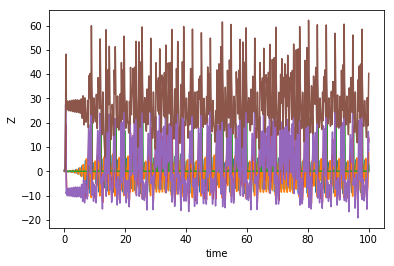

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
def model(z,t):
    x1=z[0]
    x2=z[1]
    x3=z[2]
    y1=z[3]
    y2=z[4]
    y3=z[5]
    C=2 
    dx1dt = -6*(x2+x3)
    dx2dt = 6*(x1+0.2*x2)
    dx3dt =6*(0.2+x3*(x1-5.7))
    dy1dt = 10*(-y1+y2)
    dy2dt = 28*y1-y2-y1*y3+C*(x2**2)
    dy3dt = y1*y2-(8/3)*y3
    dzdt = [dx1dt,dx2dt,dx3dt,dy1dt,dy2dt,dy3dt]
    return dzdt

# initial condition
z0 = [0,0,0.4,0.3,0.3,0.3]
n=5000
# time points
t = np.linspace(0,100,n)

# solve ODE
z = odeint(model,z0,t)

# plot results
plt.plot(t,z)
plt.xlabel('time')
plt.ylabel('Z')
plt.show()

In [0]:
z.shape

(5000, 6)

In [0]:
z

array([[ 0.00000000e+00,  0.00000000e+00,  4.00000000e-01,
         3.00000000e-01,  3.00000000e-01,  3.00000000e-01],
       [-3.58065218e-02, -2.38776823e-03,  2.18693699e-01,
         3.15046751e-01,  4.61486848e-01,  2.86685068e-01],
       [-5.53282945e-02, -8.09385791e-03,  1.27060783e-01,
         3.57621367e-01,  6.35826785e-01,  2.75372255e-01],
       ...,
       [ 1.83160997e+00,  6.97385843e+00,  1.16970399e+00,
         1.33408292e+01,  1.08871266e+01,  3.96748584e+01],
       [ 8.61882005e-01,  7.30697109e+00,  7.12092088e-01,
         1.27717485e+01,  9.59522537e+00,  4.02157207e+01],
       [-9.46407616e-02,  7.53121486e+00,  3.93731750e-01,
         1.20945342e+01,  8.56134676e+00,  4.03199680e+01]])

In [0]:
G=z[1000:2000,:]

In [0]:
G

array([[-3.20413347e+00,  2.36374112e+00,  3.38965238e-02,
        -4.02917521e+00, -3.29581106e+00,  2.28525137e+01],
       [-3.47086089e+00,  2.01537448e+00,  2.60614272e-02,
        -3.91175406e+00, -3.48067164e+00,  2.19263762e+01],
       [-3.69283160e+00,  1.62881000e+00,  2.29909577e-02,
        -3.85994468e+00, -3.77980916e+00,  2.10611251e+01],
       ...,
       [ 1.50014390e+00, -3.56029720e+00,  4.11663928e-02,
        -1.03049757e+01, -1.22487313e+01,  2.45460619e+01],
       [ 1.91558510e+00, -3.43928031e+00,  4.46510425e-02,
        -1.06473399e+01, -1.21094556e+01,  2.57618694e+01],
       [ 2.31290178e+00, -3.26588927e+00,  4.86274998e-02,
        -1.08838571e+01, -1.17736153e+01,  2.69332953e+01]])

In [0]:
G=G.transpose() 

In [0]:
G.shape

(6, 1000)

In [0]:
T=G.shape[1]


In [0]:
w=int(np.floor(2*T/4)) # window length
k_min = 0
k_max = 3

In [0]:
G.shape[1]

1000

In [0]:
st=inference(G,w,k_min,k_max,"ST").round(3)

In [0]:
st=st.reset_index()
del st["index"]
st = st.rename(columns={'Score': 'st_score'})
st["st_rank"]=range(0,st.shape[0])
st.head()

,Regulator,Regulated,st_score,Delay,st_rank
0,4,3,0.329,1,0
1,2,0,0.462,1,1
2,4,3,0.575,2,2
3,2,1,0.617,2,3
4,2,1,0.629,1,4


In [0]:
lr=inference(G,w,k_min,k_max,"LR").round(3)


In [0]:
lr=lr.reset_index()
del lr["index"]
lr = lr.rename(columns={'Score': 'lr_score'})
lr["lr_rank"]=range(0,lr.shape[0])
lr.head()

,Regulator,Regulated,lr_score,Delay,lr_rank
0,3,4,0.0,2,0
1,4,3,0.0,1,1
2,4,3,0.0,2,2
3,0,2,0.0,2,3
4,1,2,0.0,1,4


In [0]:
wald=inference(G,w,k_min,k_max,"WALD").round(3)

In [0]:
wald=wald.reset_index()
del wald["index"]
wald = wald.rename(columns={'Score': 'wald_score'})
wald["wald_rank"]=range(0,wald.shape[0])
wald.head()

,Regulator,Regulated,wald_score,Delay,wald_rank
0,4,3,0.0,1,0
1,3,4,0.0,2,1
2,4,3,0.0,2,2
3,0,2,0.0,2,3
4,1,2,0.0,1,4


In [0]:
rf=inference(G,w,k_min,k_max,"RF").round(3)

In [0]:
rf=rf.reset_index()
del rf["index"]
rf = rf.rename(columns={'Score': 'rf_score'})
rf["rf_rank"]=range(0,rf.shape[0])
rf.head()

,Regulator,Regulated,rf_score,Delay,rf_rank
0,3,5,0.851,2,0
1,4,3,0.899,2,1
2,2,0,0.903,1,2
3,3,5,0.903,1,3
4,0,2,0.906,2,4


In [0]:
st['Regulator'] =st['Regulator'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
st['Regulated'] =st['Regulated'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})

In [0]:
st

,Regulator,Regulated,st_score,Delay,st_rank
0,y2,y1,0.329,1,0
1,x3,x1,0.462,1,1
2,y2,y1,0.575,2,2
3,x3,x2,0.617,2,3
4,x3,x2,0.629,1,4
5,x3,x1,0.648,2,5
6,y2,y3,0.657,1,6
7,x1,x3,0.671,2,7
8,y3,y1,0.682,2,8
9,x1,x2,0.684,2,9


In [0]:
lr['Regulator'] =lr['Regulator'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
lr['Regulated'] =lr['Regulated'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})

In [0]:
lr

,Regulator,Regulated,lr_score,Delay,lr_rank
0,y1,y2,0.000,2,0
1,y2,y1,0.000,1,1
2,y2,y1,0.000,2,2
3,x1,x3,0.000,2,3
4,x2,x3,0.000,1,4
5,x2,x3,0.000,2,5
6,x3,x1,0.000,1,6
7,y1,y2,0.000,1,7
8,y1,y3,0.000,1,8
9,x1,x3,0.000,1,9


In [0]:
wald['Regulator'] =wald['Regulator'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
wald['Regulated'] =wald['Regulated'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})

In [0]:
wald

,Regulator,Regulated,wald_score,Delay,wald_rank
0,y2,y1,0.000,1,0
1,y1,y2,0.000,2,1
2,y2,y1,0.000,2,2
3,x1,x3,0.000,2,3
4,x2,x3,0.000,1,4
5,x2,x3,0.000,2,5
6,x3,x1,0.000,1,6
7,y1,y2,0.000,1,7
8,x2,x1,0.000,1,8
9,x2,x1,0.000,2,9


In [0]:
rf['Regulator'] =rf['Regulator'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
rf['Regulated'] =rf['Regulated'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})

In [0]:
k=rf[rf['Regulator'].str.match('x2')]
j=k[k['Regulated'].str.match('y2')]
j.values[0][4]

12

In [0]:
rf

,Regulator,Regulated,rf_score,Delay,rf_rank
0,y1,y3,0.851,2,0
1,y2,y1,0.899,2,1
2,x3,x1,0.903,1,2
3,y1,y3,0.903,1,3
4,x1,x3,0.906,2,4
5,y1,y2,0.910,1,5
6,y1,y2,0.918,2,6
7,x3,x1,0.925,2,7
8,x3,x2,0.934,2,8
9,y2,y1,0.937,1,9


In [0]:
rf[]

In [0]:
rf.shape,lr.shape,wald.shape,st.shape

((144, 5), (144, 5), (144, 5), (144, 5))

In [0]:
#st,lr,wald,rf
A=pd.merge(st,lr,on=['Regulator','Regulated',"Delay"])
A=pd.merge(A,wald,on=['Regulator','Regulated',"Delay"])
A=pd.merge(A,rf,on=['Regulator','Regulated',"Delay"])
A["Average_rank"]=(A["st_rank"]+A["lr_rank"]+A["wald_rank"]+A["rf_rank"])/4
A=A.sort_values("Average_rank")

A=A[["Regulator","Regulated","Average_rank","Delay"]]

In [0]:
A

,Regulator,Regulated,Average_rank,Delay
12,epo,epo,18.25,9
2,nao,epo,21.25,9
72,ENSO,ENSO,22.00,9
47,nao,ENSO,28.00,9
46,epo,wpo,29.00,9
6,epo,epo,33.25,8
66,ENSO,pna,38.50,7
68,nao,pna,39.25,9
3,epo,pna,41.25,7
106,ENSO,nao,42.25,9


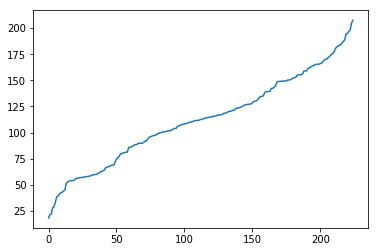

In [0]:
plt.plot(A.Average_rank.values)

In [0]:
TrueMatrix=np.zeros((6,6))

In [0]:
TrueMatrix[0,(1,2)]=1
TrueMatrix[1,(4,0)]=1
TrueMatrix[2,0]=1
TrueMatrix[3,(4,5)]=1
TrueMatrix[4,(3,5)]=1
TrueMatrix[5,(4)]=1

In [0]:
TrueMatrix

array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0.]])

In [0]:
def r_to_f1(r,TrueMatrix,tr):
  r1=list(set(r.values[:,0]))
  r2=list(set(r.values[:,1]))
  R=(list(set(r1+r2)))
  
  networkd=r[r.values[:,4]<tr].values
  EstMatrix=np.zeros((TrueMatrix.shape[0],TrueMatrix.shape[1]))
  for i in range( networkd.shape[0]):
    EstMatrix[int(networkd[i,0]),int(networkd[i,1])]=1
  f1=f1score(np.abs(TrueMatrix),EstMatrix)
  return f1

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(st,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.6666666666666666

In [0]:
np.argmax(B)

18

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(lr,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.8181818181818182

In [0]:
np.argmax(B)

22

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(wald,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.8181818181818182

In [0]:
np.argmax(B)

22

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(rf,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.7777777777777777

In [0]:
np.argmax(B)

13

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
def model(z,t):
    x1=z[0]
    x2=z[1]
    x3=z[2]
    y1=z[3]
    y2=z[4]
    y3=z[5]
    C=2 
    dx1dt = -6*(x2+x3)
    dx2dt = 6*(x1+0.2*x2)
    dx3dt =6*(0.2+x3*(x1-5.7))
    dy1dt = 10*(-y1+y2)
    dy2dt = 28*y1-y2-y1*y3+C*(x2**2)
    dy3dt = y1*y2-(8/3)*y3
    dzdt = [dx1dt,dx2dt,dx3dt,dy1dt,dy2dt,dy3dt]
    return dzdt

# initial condition
z0 = [0,0,0.4,0.3,0.3,0.3]
n=5000
# time points
t = np.linspace(0,100,n)

# solve ODE
z = odeint(model,z0,t)










In [0]:
result=np.zeros(20)

In [0]:
def RF(z):
  G=z[1000:2000,:]
  G=G.transpose() 
  T=G.shape[1]
  w=int(np.floor(2*T/4)) # window length
  k_min = 0
  k_max = 3
  rf=inference(G,w,k_min,k_max,"RF").round(3)
  rf=rf.reset_index()
  del rf["index"]
  rf = rf.rename(columns={'Score': 'rf_score'})
  rf["rf_rank"]=range(0,rf.shape[0])
  rf['Regulator'] =rf['Regulator'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
  rf['Regulated'] =rf['Regulated'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
  k=rf[rf['Regulator'].str.match('x2')]
  j=k[k['Regulated'].str.match('y2')]
  return j.values[0]



In [0]:
result

array([32., 35., 25., 15., 12., 23., 28., 24., 21., 20.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [0]:
x=[32,19,35,17,25,22,15,13,12,15,23,24,28,27,24,22,21,22,20,23]

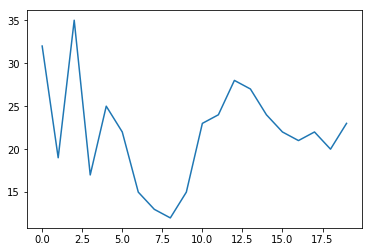

In [0]:
plt.plot(x)

In [0]:
def RF(z):
  G=z[1000:2000,:]
  G=G.transpose() 
  T=G.shape[1]
  w=int(np.floor(2*T/4)) # window length
  k_min = 0
  k_max = 3
  rf=inference(G,w,k_min,k_max,"RF").round(3)
  rf=rf.reset_index()
  del rf["index"]
  rf = rf.rename(columns={'Score': 'rf_score'})
  rf["rf_rank"]=range(0,rf.shape[0])
  rf['Regulator'] =rf['Regulator'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
  rf['Regulated'] =rf['Regulated'].map({0	:"x1",1:"x2",2:"x3",3:"y1",4:"y2",5:"y3"})
  return rf

In [0]:
dfa = pd.DataFrame()

In [0]:
for i in range(0,20,1):
  def model(z,t):
    x1=z[0]
    x2=z[1]
    x3=z[2]
    y1=z[3]
    y2=z[4]
    y3=z[5]
    C=i/4 
    dx1dt = -6*(x2+x3)
    dx2dt = 6*(x1+0.2*x2)
    dx3dt =6*(0.2+x3*(x1-5.7))
    dy1dt = 10*(-y1+y2)
    dy2dt = 28*y1-y2-y1*y3+C*(x2**2)
    dy3dt = y1*y2-(8/3)*y3
    dzdt = [dx1dt,dx2dt,dx3dt,dy1dt,dy2dt,dy3dt]
    return dzdt

  # initial condition
  z0 = [0,0,0.4,0.3,0.3,0.3]
  n=5000
  # time points
  t = np.linspace(0,100,n)

  # solve ODE
  z = odeint(model,z0,t)
  df=RF(z)
  df['C'] =i/4
  dfa = pd.concat((dfa,df))

In [0]:
dfa[]

In [0]:
dfa

,Regulator,Regulated,rf_score,Delay,rf_rank,C
0,y2,y1,0.892,2,0,0.00
1,y1,y3,0.895,2,1,0.00
2,y1,y2,0.896,1,2,0.00
3,x1,x3,0.898,2,3,0.00
4,x3,x1,0.899,1,4,0.00
5,y1,y2,0.908,2,5,0.00
6,x3,x1,0.918,2,6,0.00
7,y1,y3,0.920,1,7,0.00
8,y2,y1,0.929,1,8,0.00
9,x3,x2,0.933,2,9,0.00


In [0]:
k=dfa[dfa['Regulator'].str.match('x2')]
j=k[k['Regulated'].str.match('y2')]
l=j[j['C']==0]

In [0]:
l.values[0][2]

0.992

In [0]:

m=dfa[dfa['C']==0]

In [0]:
m.values[0][2]

0.892

In [0]:
for i in range(0,20,1):
  k=dfa[dfa['Regulator'].str.match('x2')]
  j=k[k['Regulated'].str.match('y2')]
  l=j[j['C']==i/4]
  c=l.values[0][2]
  m=dfa[dfa['C']==i/4]
  f=m.values[0][2]
  print((1-c)/(1-f))
    

  


0.07407407407407415
0.16822429906542075
0.06716417910447767
0.1397058823529413
0.11940298507462696
0.10000000000000007
0.14465408805031457
0.17449664429530215
0.1946308724832216
0.18181818181818196
0.141891891891892
0.11920529801324511
0.10559006211180132
0.11445783132530128
0.11309523809523817
0.11904761904761912
0.11242603550295865
0.11046511627906984
0.1136363636363637
0.10169491525423735


In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
dfa.to_csv('dfa.csv')
!cp dfa.csv drive/My\ Drive/